### 문서유사도
* 문서 <-> 문서 : 코사인 유사도(Cosine similarity)
    - 벡터 <-> 벡터 유사도 비교시 벡터의 크기보다 벡터의 상호방향성이 얼마나 유사한지 기반
    - A * B = ||A|| ||B|| cos@
    - 유사도 = cos@ = (AdotB : 내적) / 벡터크기
    - ==> 내적결과를 총 벡터크기로 정규화(L2 Norm)
    - ||A|| = 루트(시그마A^2)
* 코사인유사도를 문서의 유사도로 많이 사용하는 이유
    - 문서를 피처벡터화 변환하면 차원이 매우 많은 희소행렬이 되기 쉽다
    - 희소행렬기반에서 문서와 문서벡터간의 크기에 기반한 유사도 지표(예, 유클리드 거리기반) 정확도 떨어짐
    - 문서가 매우 긴 경우 단어의 빈도수도 더 많아 빈도수에 기반하면 공정한 비교되지 않음

In [2]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity


In [3]:
# TF-IDF 벡터화된 희소행렬로 변환
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [20]:
# 희소행렬이 cos_similarity의 인자가 되기 위해 밀집행렬로 변환 한 뒤 다시 각각 배열로 변환 

# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환. 
feature_vect_dense = feature_vect_simple.todense()
# print(feature_vect_dense.shape) # (3, 18)

# 첫번째 문장과 두번째 문장의 feature vector  추출 -> 각각 배열로 변환,
# 차원 변경 : reshape(-1) 
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
# print(vect1.shape, vect2.shape) # (18,) (18,)

#첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
similarity_simple = cos_similarity(vect1, vect2 )
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402
문장 2, 문장 3 Cosine 유사도: 0.456


In [5]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1, vect3 )
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2, vect3 )
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


In [ ]:
#### sklearn API cosine_similarity 이용
* cosine_similarity 두 개의 인자(비교기준이 되는 문서의 피처행렬, 비교되는 문서의 피처행렬)
    - 희소행렬,밀집행렬 모두 가능 (행렬 또는 배열 모두 가능)
    - cos_similarity()와 같은 별도의 변환작업 필요없음 ( 희소 -> 밀집 -> 배열), 희소자체 사용

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple)
print(similarity_simple_pair)
# [[ 비교기준자신과비교, 첫번째문서, 두번째문서]]


[[1.         0.40207758 0.40425045]]


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# 비교기준과 첫번째문서, 두번째문서와 비교 slicing
similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple[1:])
print(similarity_simple_pair)


[[0.40207758 0.40425045]]


In [8]:
# Pair 코사인유사도값 제공 (비교기준이 돌아가면서 첫번째문서, 두번째, 세번째)
similarity_simple_pair = cosine_similarity(feature_vect_simple , feature_vect_simple)
print(similarity_simple_pair)
print('shape:',similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


In [ ]:
### Opinion Review 데이터 셋을 이용한 문서 유사도 측정

In [9]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [12]:
import pandas as pd
import glob ,os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'/home/jovyan/work/ml-definitive-guide/8장/OpinosisDataset1.0/topics'
all_files = glob.glob(os.path.join(path, "*.data"))     
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    filename_ = file_.split('/')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [14]:
document_df.head()

,filename,opinion_text,cluster_label
0,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and...",1
1,mileage_honda_accord_2008,"It's quiet, get good gas mileage and look...",0
2,quality_toyota_camry_2007,I previously owned a Toyota 4Runner which ...,0
3,service_swissotel_hotel_chicago,Mediocre room and service for a very extr...,1
4,buttons_amazon_kindle,I thought it would be fitting to christen ...,2


In [13]:
# 호텔에 대하여 문서 코사인유사도

from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시. ==> 비교기준 문서로 선정 
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ',comparison_docname,' 와 타 문서 유사도######')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]] , feature_vect[hotel_indexes])
print(similarity_pair)


호텔로 클러스터링 된 문서들의 DataFrame Index: Int64Index([0, 3, 7, 9, 12, 15, 24, 25, 26, 33, 35, 41, 43, 48, 49, 50], dtype='int64')
##### 비교 기준 문서명  bathroom_bestwestern_hotel_sfo  와 타 문서 유사도######
[[1.         0.1602411  0.05404862 0.04017338 0.05839754 0.06629355
  0.05539602 0.05907195 0.3871916  0.57253197 0.06734556 0.41011101
  0.03739629 0.13058128 0.10600704 0.13113702]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

In [80]:
print(hotel_1_sim_df.shape)
hotel_1_sim_df.head()

(15, 2)


,filename,similarity
33,room_holiday_inn_london,0.572532
41,rooms_bestwestern_hotel_sfo,0.410111
26,rooms_swissotel_chicago,0.387192
3,service_swissotel_hotel_chicago,0.160241
50,price_holiday_inn_london,0.131137


In [48]:
import numpy as np

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

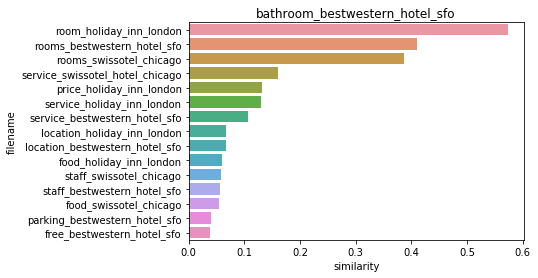

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.barplot(x='similarity', y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)

In [81]:
print(len(hotel_1_sim_df))

15


Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

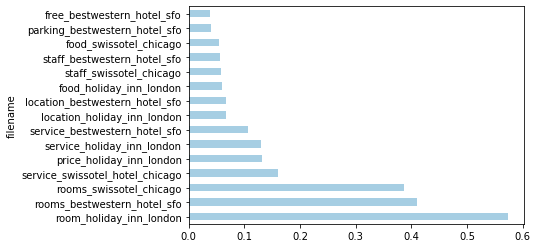

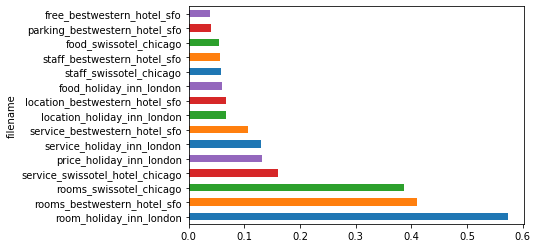

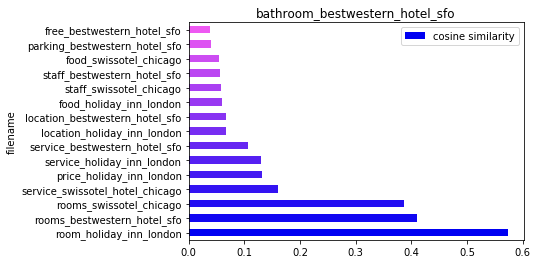

In [92]:
# 판다스로 단색
hotel_1_sim_df.plot(kind='barh', x='filename', y='similarity', label='cosine similarity',legend=False, stacked='True', colormap='Paired') # colorbar는 scatter에만
#otel_1_sim_df.plot.barh(x='filename', y='similarity', label='cosine similarity',legend=False, colormap='Paired') 

# 판다스로 여러색
hotel_1_sim_df.plot(kind='barh', x='filename', y='similarity', label='cosine similarity',legend=False, color=['C0', 'C1','C2','C3','C4'])

from itertools import cycle, islice
# Make a list by cycling through the colors you care about to match the length of your data.
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(hotel_1_sim_df)))

my_colors2 = ['g', 'b']*5 # <-- this concatenates the list to itself 5 times.
my_colors3 = [(0.5,0.4,0.5), (0.75, 0.75, 0.25)]*5 # <-- make two custom RGBs and repeat/alternate them over all the bar elements.
my_colors4 = [(x/15.0, x/40.0, 0.95) for x in range(len(hotel_1_sim_df))] # <-- Quick gradient example along the Red/Green dimensions.
                                                                          # RGB value shoud be 0 - 1
hotel_1_sim_df.plot(kind='barh', x='filename', y='similarity', label='cosine similarity',legend=False, color=my_colors4)
plt.legend()
plt.title(comparison_docname)
#plt.show()